Orchestrating Jobs with Amazon SageMaker Model Building Pipelines

Amazon SageMaker Model Building Pipelines offers machine learning (ML) application developers and operations engineers the ability to orchestrate SageMaker jobs and author reproducible ML pipelines. It also enables them to deploy custom-build models for inference in real-time with low latency, run offline inferences with Batch Transform, and track lineage of artifacts. They can institute sound operational practices in deploying and monitoring production workflows, deploying model artifacts, and tracking artifact lineage through a simple interface, adhering to safety and best practice paradigms for ML application development.

The SageMaker Pipelines service supports a SageMaker Pipeline domain specific language (DSL), which is a declarative JSON specification. This DSL defines a directed acyclic graph (DAG) of pipeline parameters and SageMaker job steps. The SageMaker Python Software Developer Kit (SDK) streamlines the generation of the pipeline DSL using constructs that engineers and scientists are already familiar with.
SageMaker Pipelines

SageMaker Pipelines supports the following activities, which are demonstrated in this notebook:

    Pipelines - A DAG of steps and conditions to orchestrate SageMaker jobs and resource creation.
    Processing job steps - A simplified, managed experience on SageMaker to run data processing workloads, such as feature engineering, data validation, model evaluation, and model interpretation.
    Training job steps - An iterative process that teaches a model to make predictions by presenting examples from a training dataset.
    Conditional execution steps - A step that provides conditional execution of branches in a pipeline.
    Register model steps - A step that creates a model package resource in the Model Registry that can be used to create deployable models in Amazon SageMaker.
    Create model steps - A step that creates a model for use in transform steps or later publication as an endpoint.
    Transform job steps - A batch transform to preprocess datasets to remove noise or bias that interferes with training or inference from a dataset, get inferences from large datasets, and run inference when a persistent endpoint is not needed.
    Fail steps - A step that stops a pipeline execution and marks the pipeline execution as failed.
    Parametrized Pipeline executions - Enables variation in pipeline executions according to specified parameters.



In [1]:
import subprocess
subprocess.run("pip install --upgrade sagemaker",shell=True)
import os
import boto3
import glob
import sagemaker
import logging
import pandas as pd
subprocess.run("pip install sklearn",shell=True)
from sklearn.model_selection import train_test_split
sagemaker_session = sagemaker.session.Session()
region = sagemaker_session.boto_region_name
role = sagemaker.get_execution_role()
default_bucket = sagemaker_session.default_bucket()
model_package_group_name = f"ICMModelPackageGroupName"


A SageMaker Pipeline

The pipeline that you create follows a typical machine learning (ML) application pattern of preprocessing, training, evaluation, model creation, batch transformation, and model registration
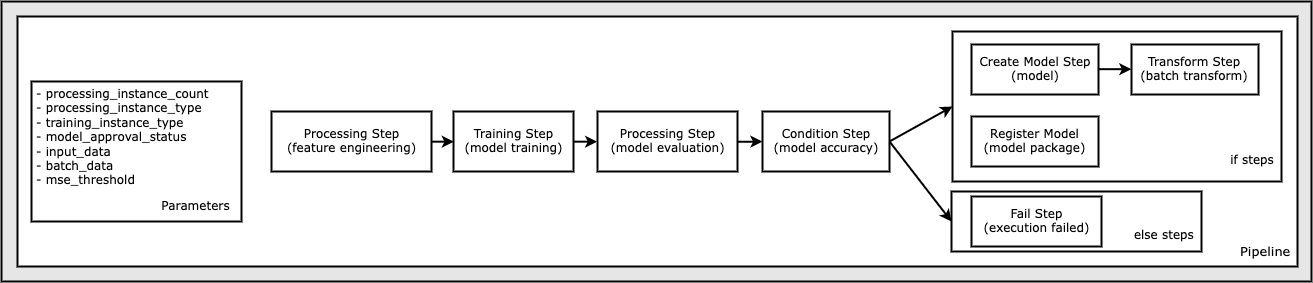

In [2]:
s3 = boto3.resource("s3")
local_path = "data"
base_uri = f"s3://{default_bucket}/ICM"
subprocess.run("mkdir -p data/tabled",shell =True)

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())
logger.info("Downloading data from bucket: %s, key: %s","inox-icm-bt", "icm_data")
s3 = boto3.resource("s3")
s3.Bucket("inox-icm-bt").download_file("icm_data/Advertisement.txt", local_path+'/Advertisement.txt')
s3.Bucket("inox-icm-bt").download_file('icm_data/CallCentreServices.txt', local_path+'/CallCentreServices.txt')
s3.Bucket("inox-icm-bt").download_file('icm_data/Commissions.txt', local_path+'/Commissions.txt')
s3.Bucket("inox-icm-bt").download_file('icm_data/GeneralContractualServices.txt', local_path+'/GeneralContractualServices.txt')
s3.Bucket("inox-icm-bt").download_file('icm_data/Goods.txt', local_path+'/Goods.txt')
s3.Bucket("inox-icm-bt").download_file('icm_data/NonTaxable.txt', local_path+'/NonTaxable.txt')
s3.Bucket("inox-icm-bt").download_file('icm_data/Professional.txt', local_path+'/Professional.txt')
s3.Bucket("inox-icm-bt").download_file('icm_data/Rent_Ia.txt', local_path+'/Rent_Ia.txt')
s3.Bucket("inox-icm-bt").download_file('icm_data/Rent_Ib.txt', local_path+'/Rent_Ib.txt')
s3.Bucket("inox-icm-bt").download_file('icm_data/Royalty.txt', local_path+'/Royalty.txt')
s3.Bucket("inox-icm-bt").download_file('icm_data/RoyaltyOther.txt', local_path+'/RoyaltyOther.txt')
s3.Bucket("inox-icm-bt").download_file('icm_data/Technical.txt', local_path+'/Technical.txt')
s3.Bucket("inox-icm-bt").download_file('icm_data/Transportation.txt', local_path+'/Transportation.txt')

file_list = glob.glob(os.path.join(local_path, "*.txt"))
print(file_list)
df = pd.DataFrame()
for tag in file_list:
    data = pd.read_csv(tag,sep='\n',header=None,names=['Text','label'])
    data['label']=tag.split('/')[-1][:-4]
    df = pd.concat([df,data],axis=0)

# we need to reshuffle the dataframe
df = df.sample(frac = 1)
df = df.drop_duplicates(subset = ['Text', 'label']).reset_index(drop = True)
df["word_count"] = df["Text"].apply(lambda x: len(str(x).split()))
stat=dict(df["word_count"].describe())
# Rule_IQR_Range = stat['75%'] + 1.5 * (stat['75%']-stat['25%'])
no_text = df[df["word_count"] == 1]
# drop these rows with 1 word
df.drop(no_text.index, inplace=True)
# long_text = df[(df["word_count"] > (Rule_IQR_Range+1))]
# drop these rows
# df.drop(long_text.index, inplace=True)
df.drop(columns="word_count", axis=1, inplace=True)

# split imbalanced dataset into train and test sets with stratification
# split into train test sets
train, validation = train_test_split(df, test_size=0.05, random_state=6)
test = df.sample(frac=0.06)

# to train on full dataset use the hyperparameter and then train by unhashing below
# train = df
# test = df.sample(frac=0.06)
# validation = test.copy()

logger.info(f"Writing out datasets to default bucket in csv format {default_bucket}/ICM")
train.to_csv(f"{local_path}/tabled/train.csv", index=False)
validation.to_csv(f"{local_path}/tabled/validation.csv", index=False)
test.to_csv(f"{local_path}/tabled/test.csv", index=False)

input_data_uri = sagemaker.s3.S3Uploader.upload(
    local_path=f"{local_path}/tabled",
    desired_s3_uri=base_uri,
)
print(input_data_uri)

['data/GeneralContractualServices.txt', 'data/Rent_Ia.txt', 'data/RoyaltyOther.txt', 'data/Royalty.txt', 'data/Commissions.txt', 'data/NonTaxable.txt', 'data/Goods.txt', 'data/Transportation.txt', 'data/Rent_Ib.txt', 'data/Technical.txt', 'data/Advertisement.txt', 'data/Professional.txt', 'data/CallCentreServices.txt']


Writing out datasets to default bucket in csv format sagemaker-us-west-2-430758128697/ICM


s3://sagemaker-us-west-2-430758128697/ICM



Define Parameters to Parametrize Pipeline Execution

Define Pipeline parameters that you can use to parametrize the pipeline. Parameters enable custom pipeline executions and schedules without having to modify the Pipeline definition.

The supported parameter types include:

    ParameterString - represents a str Python type
    ParameterInteger - represents an int Python type
    ParameterFloat - represents a float Python type

These parameters support providing a default value, which can be overridden on pipeline execution. The default value specified should be an instance of the type of the parameter.

The parameters defined in this workflow include:

    processing_instance_type - The ml.* instance type of the processing job.
    processing_instance_count - The instance count of the processing job.
    training_instance_type - The ml.* instance type of the training job.
    model_approval_status - The approval status to register with the trained model for CI/CD purposes ("PendingManualApproval" is the default).
    input_data - The S3 bucket URI location of the input data.
    acc_threshold - The Accuracy threshold used to verify the accuracy of a model.



In [3]:
from sagemaker.workflow.parameters import (
    ParameterInteger,
    ParameterString,
    ParameterFloat,
)

processing_instance_count = ParameterInteger(name="ProcessingInstanceCount", default_value=1)
processing_instance_type = ParameterString(name="ProcessingInstanceType", default_value=f'ml.m5.xlarge')
training_instance_type = ParameterString(name="TrainingInstanceType", default_value=f'ml.m5.xlarge')
model_approval_status = ParameterString(name="ModelApprovalStatus", default_value=f'PendingManualApproval')
input_data = ParameterString(
    name="InputData",
    default_value=input_data_uri,
)
# batch_data = ParameterString(
#     name="BatchData",
#     default_value=batch_data_uri,
# )
acc_threshold = ParameterFloat(name="AccThreshold", default_value=0.92)

In [4]:
from sagemaker.sklearn.processing import SKLearnProcessor

framework_version = "0.23-1"

sklearn_processor = SKLearnProcessor(
    framework_version=framework_version,
    instance_type='ml.m5.xlarge',
    instance_count=processing_instance_count,
    base_job_name="sklearn-ICM-process",
    role=role,
)

Same images used for training and inference. Defaulting to image scope: inference.
Defaulting to only available Python version: py3




Finally, use the processor instance to construct a ProcessingStep, along with the input and output channels, and the code that will be executed when the pipeline invokes pipeline execution. This is similar to a processor instance's run method in the Python SDK.

Note the input_data parameters passed into ProcessingStep is the input data used in the step. This input data is used by the processor instance when it is run.

Also, note the "train_data" and "test_data" named channels specified in the output configuration for the processing job. Step Properties can be used in subsequent steps and resolve to their runtime values at execution. Specifically, this usage is called out when you define the training step.


In [5]:
from sagemaker.processing import ProcessingInput, ProcessingOutput, ScriptProcessor
from sagemaker.workflow.steps import ProcessingStep

step_process = ProcessingStep(
    name="ICMProcess",
    processor=sklearn_processor,
    inputs=[
        ProcessingInput(source=input_data, destination="/opt/ml/processing/input"),
    ],
    outputs=[
        ProcessingOutput(output_name="train", source="/opt/ml/processing/train"),
        ProcessingOutput(output_name="validation", source="/opt/ml/processing/validation"),
        ProcessingOutput(output_name="test", source="/opt/ml/processing/test")
    ],
    code=os.path.join("pipelines", "icm", "preprocessing.py"))

Define a Training Step to Train a Model

In [6]:
from sagemaker.estimator import Estimator


model_path = f"s3://{default_bucket}/ICMTrain"
image_uri = sagemaker.image_uris.retrieve(
    framework="blazingtext",
    region=region,
    version="latest",
    py_version="py3",
    instance_type='ml.m5.xlarge',
)
region_name = boto3.Session().region_name
# container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name,"blazingtext", "latest")
print("Using SageMaker BlazingText container: {} ({})".format(image_uri, region_name))
bt_train = Estimator(
image_uri,
role,
instance_count=1,
base_job_name="ICM-train",
instance_type='ml.m5.xlarge',
volume_size=30,
#     max_run=360000,
input_mode="File",
output_path=model_path,
hyperparameters={
    "mode": "supervised",
    "epochs": 16,
    "learning_rate": 0.06049598865396785,
    "min_epochs": 5,
    "word_ngrams": 2,
    },
)

Same images used for training and inference. Defaulting to image scope: inference.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.
Ignoring unnecessary Python version: py3.
Ignoring unnecessary instance type: ml.m5.xlarge.


Using SageMaker BlazingText container: 433757028032.dkr.ecr.us-west-2.amazonaws.com/blazingtext:1 (us-west-2)




Finally, use the estimator instance to construct a TrainingStep as well as the properties of the prior ProcessingStep used as input in the TrainingStep inputs and the code that's executed when the pipeline invokes the pipeline execution. This is similar to an estimator's fit method in the Python SDK.

Pass in the S3Uri of the "train_data" output channel to the TrainingStep. Also, use the other "test_data" output channel for model evaluation in the pipeline. The properties attribute of a Pipeline step matches the object model of the corresponding response of a describe call. These properties can be referenced as placeholder values and are resolved at runtime. For example, the ProcessingStep properties attribute matches the object model of the DescribeProcessingJob response object.


In [7]:
from sagemaker.inputs import TrainingInput
from sagemaker.workflow.steps import TrainingStep


step_train = TrainingStep(
    name="ICMTrain",
    estimator=bt_train,
    inputs={
        "train": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs["train"].S3Output.S3Uri,
            content_type="text/csv",
        ),
        "validation": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs["validation"].S3Output.S3Uri,
            content_type="text/csv",
        ),
    },
)

In [8]:
from sagemaker.processing import ScriptProcessor

script_eval = ScriptProcessor(
    image_uri=image_uri,
    command=["python3"],
    instance_type=processing_instance_type,
    instance_count=1,
    base_job_name="script-ICM-eval",
    role=role,
)



Use the processor instance to construct a ProcessingStep, along with the input and output channels and the code that will be executed when the pipeline invokes pipeline execution. This is similar to a processor instance's run method in the Python SDK.

Specifically, the S3ModelArtifacts from the step_train properties and the S3Uri of the "test_data" output channel of the step_process properties are passed as inputs. The TrainingStep and ProcessingStep properties attribute matches the object model of the DescribeTrainingJob and DescribeProcessingJob response objects, respectively.


#### Step_Eval

In [9]:
from typing import List
from sagemaker.workflow.properties import PropertyFile

def get_processing_step(
    processor_type: str,
    sagemaker_session: sagemaker_session,
    role: str,
    pipeline_name: str,
    step_name: str,
    instance_type: str,
    instance_count: int,
    inputs: List[ProcessingInput],
    outputs: List[ProcessingOutput],
    code_path: str,
    property_files: List[PropertyFile] = None,
    job_arguments: List[str] = None
) -> ProcessingStep:
    return ProcessingStep(
        name=step_name,
        processor=get_processor(
            processor_type=processor_type,
            sagemaker_session=sagemaker_session,
            role=role,
            base_job_name=f"ICM{step_name}",
            instance_type=instance_type,
            instance_count=instance_count),
        inputs=inputs,
        outputs=outputs,
        code=code_path,
        property_files=property_files,
        job_arguments=job_arguments
    )
def get_processor(
    processor_type: str,
    sagemaker_session: sagemaker_session,
    role: str,
    base_job_name: str,
    instance_type: str,
    instance_count: int,
) -> ScriptProcessor:
    kwargs = {
        "instance_type": instance_type,
        "instance_count": instance_count,
        "base_job_name": base_job_name,
        "sagemaker_session": sagemaker_session,
        "role": role
    }

    if processor_type == "sklearn":
        return SKLearnProcessor(
            framework_version="0.23-1",
            **kwargs
        )
    elif processor_type == "blazingtext":
        return ScriptProcessor(
            image_uri=image_uri,
            command=['python3'],
            **kwargs
        )
    else:
        raise ValueError(f"Unsupported estimator type for processing processor: {processor_type}")
evaluation_report =  PropertyFile(
                name="ICMEvaluationReport",
                output_name="evaluation",
                path="evaluation.json")

step_eval = get_processing_step(
        processor_type="blazingtext",
        sagemaker_session=sagemaker_session,
        role=role,
        pipeline_name="ICM",
        step_name="ICMEval",
        instance_type="ml.m5.xlarge",
        instance_count=1,
        inputs=[
            ProcessingInput(
                input_name="test",
                source="s3://inox-icm-bt/test_data/test.csv",
                destination="/opt/ml/processing/test"),
            ProcessingInput(
                input_name="model",
                source=step_train.properties.ModelArtifacts.S3ModelArtifacts,
                destination="/opt/ml/processing/model"),
        ],
        outputs=[
            ProcessingOutput(
                output_name="evaluation_report",
                source="/opt/ml/processing/evaluation")
        ],
        code_path=os.path.join("pipelines", "icm", "evaluation.py"),
        property_files=[evaluation_report]
    )


In [10]:
def accuracy_pred():  
#     s3.Bucket("inox-icm-bt").download_file("blazingtext/output/blazingtext-2022-04-26-07-32-33-533/output/model.tar.gz","model.tar.gz")
#     subprocess.run("pip install fasttext",shell=True)
    import fasttext
#     import tarfile
    import pandas as pd
    from sklearn.metrics import accuracy_score
#     model_path = "model.tar.gz"
#     with tarfile.open(model_path) as tar:
#         tar.extractall(path=".")

    model = fasttext.load_model('model.bin')

    test_path = "data/tabled/validation.csv"
    df = pd.read_csv(test_path)
    df_pro = preprocess_line(df.Text)
    pred = []
    for i in df_pro:
        pred.append(str(model.predict(i)[0])[11:-3])

    accuracy = accuracy_score(df.label, pred)
    return accuracy

In [11]:
accuracy = 0.95916666666666
# or can run below script to find the accuracy again but is already calculated in the training step and can be checked in the logs of training step 
# accuracy = accuracy_pred()

In [12]:
accuracy

0.95916666666666


Define a Create Model Step to Create a Model

In order to perform batch transformation using the example model, create a SageMaker model.

Specifically, pass in the S3ModelArtifacts from the TrainingStep, step_train properties. The TrainingStep properties attribute matches the object model of the DescribeTrainingJob response object.


In [13]:
from sagemaker.sklearn import SKLearnModel
from sagemaker import Model, PipelineModel, Session, image_uris
from typing import List
def get_sklearn_model1(
    sagemaker_session: Session,
    role: str,
    model_data: str,
    entry_point: str,
    code_location: str,
) -> Model:
    return SKLearnModel(
        name="sklearn1",
        sagemaker_session=sagemaker_session,
        dependencies=['requirements.txt'],
        role=role,
        model_data=model_data,
        entry_point=entry_point,
        code_location=code_location,
        framework_version="0.23-1",
        py_version="py3")
def get_sklearn_model2(
    sagemaker_session: Session,
    role: str,
    model_data: str,
    entry_point: str,
    code_location: str,
) -> Model:
    return SKLearnModel(
        name="sklearn2",
        sagemaker_session=sagemaker_session,
        dependencies=['requirements.txt'],
        role=role,
        model_data=model_data,
        entry_point=entry_point,
        code_location=code_location,
        framework_version="0.23-1",
        py_version="py3")

def get_pipeline_model(
    models: List[Model],
    sagemaker_session: Session,
    role: str
) -> PipelineModel:
    return PipelineModel(
        models=models,
        sagemaker_session=sagemaker_session,
        role=role)

def get_bt_model(
    sagemaker_session: Session,
    role: str,
    model_data: str,
    instance_type: str
) -> Model:
    return Model(
        name="blazingtext",
        model_data=model_data,
        image_uri=get_bt_image_uri(
            sagemaker_session=sagemaker_session,
            instance_type=instance_type,
            image_scope="inference"),
        role=role,
        sagemaker_session=sagemaker_session)

def get_bt_image_uri(
    sagemaker_session: Session,
    instance_type: str,
    image_scope: str = None
) -> str:
    return image_uris.retrieve(
        framework="blazingtext",
        region=sagemaker_session.boto_session.region_name,
        version="latest",
        py_version="py3",
        instance_type='ml.m5.xlarge',
        image_scope="inference")

model=get_pipeline_model(
        models=[
            get_sklearn_model1(
                sagemaker_session=sagemaker_session,
                role=role,
                model_data="s3://inox-icm-bt/model/model.tar.gz",
                entry_point=os.path.join("pipelines", "icm", "icm_inference.py"),
                code_location=f"{input_data_uri}/code/sklearn-inference1"),
            get_bt_model(
                    sagemaker_session=sagemaker_session,
                    role=role,
                    model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
                    instance_type="ml.m5.xlarge"
                ),
            get_sklearn_model2(
                sagemaker_session=sagemaker_session,
                role=role,
                model_data="s3://inox-icm-bt/model/model.tar.gz",
                entry_point=os.path.join("pipelines", "icm", "icm_postprocessing.py"),
                code_location=f"{input_data_uri}/code/sklearn-inference2")
        ],
        sagemaker_session=sagemaker_session,
        role=role)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.
Ignoring unnecessary Python version: py3.
Ignoring unnecessary instance type: ml.m5.xlarge.


#### Creating model for above defined pipeline model

In [14]:
from sagemaker.inputs import CreateModelInput
from sagemaker.workflow.steps import CreateModelStep

inputs = CreateModelInput(
    instance_type="ml.m5.large",
    accelerator_type="ml.eia1.medium",
)
step_create_model = CreateModelStep(
    name="ICMCreateModel",
    model=model,
    inputs=inputs,
)


Define a Transform Step to Perform Batch Transformation

Now that a model instance is defined, create a Transformer instance with the appropriate model type, compute instance type, and desired output S3 URI.

Specifically, pass in the ModelName from the CreateModelStep, step_create_model properties. The CreateModelStep properties attribute matches the object model of the DescribeModel response object.


In [15]:
# # hashed as we dont need batch transform job as of now but if required can be used by providing the location for the batch job uri
# from sagemaker.transformer import Transformer

# transformer = Transformer(
#     model_name=step_create_model.properties.ModelName,
#     instance_type="ml.m5.xlarge",
#     instance_count=1,
#     output_path=f"s3://{default_bucket}/ICMTransform",
# )
# from sagemaker.inputs import TransformInput
# from sagemaker.workflow.steps import TransformStep


# step_transform = TransformStep(
#     name="ICMTransform", transformer=transformer, inputs=TransformInput(data=batch_data)
# )


Define a Register Model Step to Create a Model Package

Use the estimator instance specified in the training step to construct an instance of RegisterModel. The result of executing RegisterModel in a pipeline is a model package. A model package is an abstraction of reusable model artifacts that packages all ingredients required for inference. Primarily, it consists of an inference specification that defines the inference image to use along with an optional model weights location.

A model package group is a collection of model packages. A model package group can be created for a specific ML business problem, and new versions of the model packages can be added to it. Typically, customers are expected to create a ModelPackageGroup for a SageMaker pipeline so that model package versions can be added to the group for every SageMaker Pipeline run.

The construction of RegisterModel is similar to an estimator instance's register method in the Python SDK.

Specifically, pass in the S3ModelArtifacts from the TrainingStep, step_train properties. The TrainingStep properties attribute matches the object model of the DescribeTrainingJob response object.

Note that the specific model package group name provided in this notebook can be used in the model registry and CI/CD work with SageMaker Projects.


In [16]:
from sagemaker.model_metrics import MetricsSource, ModelMetrics
from sagemaker.workflow.step_collections import RegisterModel
from sagemaker.sklearn import SKLearnModel
from sagemaker import Model, PipelineModel, Session, image_uris
from typing import List
from pipelines.icm.register_step import get_register_step

# register serial inference pipeline model step
step_register = get_register_step(
    pipeline_name="ICMRegisterModel",
    step_name="RegisterSerialInferencePipelineModel",
    instance_type="ml.m5.xlarge",
    model=get_pipeline_model(
        models=[
            get_sklearn_model1(
                sagemaker_session=sagemaker_session,
                role=role,
                model_data="s3://inox-icm-bt/model/model.tar.gz",
                entry_point=os.path.join("pipelines", "icm", "icm_inference.py"),
                code_location=f"{input_data_uri}/code/sklearn-inference1"),
            get_bt_model(
                    sagemaker_session=sagemaker_session,
                    role=role,
                    model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
                    instance_type='ml.m5.xlarge'
                ),
            get_sklearn_model2(
                sagemaker_session=sagemaker_session,
                role=role,
                model_data="s3://inox-icm-bt/model/model.tar.gz",
                entry_point=os.path.join("pipelines", "icm", "icm_postprocessing.py"),
                code_location=f"{input_data_uri}/code/sklearn-inference2")
        ],
        sagemaker_session=sagemaker_session,
        role=role),
    content_types=["text/csv"],
    response_types=["application/json"],
    model_metrics_location="{}/evaluation.json".format(step_process.arguments["ProcessingOutputConfig"]["Outputs"][0]["S3Output"]["S3Uri"])
)


Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.
Ignoring unnecessary Python version: py3.
Ignoring unnecessary instance type: ml.m5.xlarge.
The class RegisterModel has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Same images used for training and inference. Defaulting to image scope: inference.
Same images used for training and inference. Defaulting to image scope: inference.
Same images used for training and inference. Defaulting to image scope: inference.
Same images used for training and inference. Defaulting to image scope: inference.


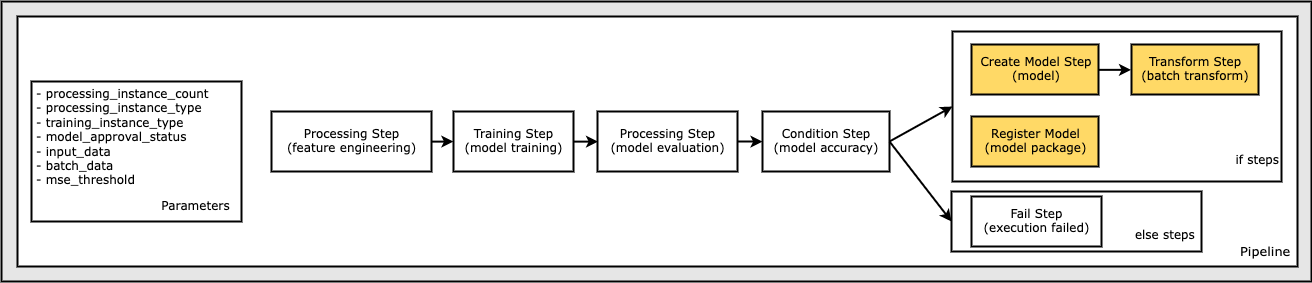


Define a Fail Step to Terminate the Pipeline Execution and Mark it as Failed

This section walks you through the following steps:

    Define a FailStep with customized error message, which indicates the cause of the execution failure.
    Enter the FailStep error message with a Join function, which appends a static text string with the dynamic mse_threshold parameter to build a more informative error message.



In [17]:
from sagemaker.workflow.fail_step import FailStep
from sagemaker.workflow.functions import Join

step_fail = FailStep(
    name="ICMAccFail",
    error_message=Join(on=" ", values=["Execution failed due to accuracy < ", acc_threshold]),
)

### Commit step of the model

In [18]:
# from typing import List
# from sagemaker.lambda_helper import Lambda
# from sagemaker.workflow.lambda_step import LambdaStep, LambdaOutput, LambdaOutputTypeEnum
# pipeline_name = f"ICMPipeline"
# MODEL_SNAPSHOT_REPOSITORY = "ICMModelRegistrySnapshot"
# MAINLINE = "mainline"


# def get_commit_step(
#     sagemaker_session: sagemaker_session,
#     role: str,
#     pipeline_name: str,
#     step_name: str,
#     script: str,
#     handler: str,
#     depends_on: List[str] = None
# ) -> LambdaStep:
#     return LambdaStep(
#         name=step_name,
#         lambda_func=Lambda(
#             session=sagemaker_session,
#             function_name="ModelSnapshotCommitter",
#             execution_role_arn=role,
#             script=script,
#             handler=handler
#         ),
#         inputs={
#             "model_name": pipeline_name,
#             "repository_name": MODEL_SNAPSHOT_REPOSITORY,
#             "branch_name": MAINLINE
#         },
#         outputs=[
#             LambdaOutput(output_name="statusCode", output_type=LambdaOutputTypeEnum.Integer),
#             LambdaOutput(output_name="body", output_type=LambdaOutputTypeEnum.String)],
#         depends_on=depends_on)

# # commit model snapshot step
# step_commit = get_commit_step(
#     sagemaker_session=sagemaker_session,
#     role=role,
#     pipeline_name=pipeline_name,
#     step_name="step_commit",
#     script=os.path.join("pipelines","icm","handler.py"),
#     handler="handler.lambda_handler",
#     depends_on=["RegisterSerialInferencePipelineModel"]
# )

Define a Condition Step to Check Accuracy and Conditionally Create a Model and Run a Batch Transformation and Register a Model in the Model Registry, Or Terminate the Execution in Failed State

In [19]:
from sagemaker.workflow.conditions import ConditionGreaterThanOrEqualTo
from sagemaker.workflow.condition_step import ConditionStep
from sagemaker.workflow.functions import JsonGet

cond_lte = ConditionGreaterThanOrEqualTo(
    left=accuracy,
    right=acc_threshold,
)

step_cond = ConditionStep(
    name="ICMAccCond",
    conditions=[cond_lte],
    if_steps=[step_register, step_create_model],
    else_steps=[step_fail],
)


Define a Pipeline of Parameters, Steps, and Conditions

In this section, combine the steps into a Pipeline so it can be executed.

A pipeline requires a name, parameters, and steps. Names must be unique within an (account, region) pair.

Note:

    All the parameters used in the definitions must be present.
    Steps passed into the pipeline do not have to be listed in the order of execution. The SageMaker Pipeline service resolves the data dependency DAG as steps for the execution to complete.
    Steps must be unique to across the pipeline step list and all condition step if/else lists.



In [20]:
from sagemaker.workflow.pipeline import Pipeline

pipeline_name = f"ICMPipeline"
pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        processing_instance_type,
        processing_instance_count,
        training_instance_type,
        model_approval_status,
        input_data,
        acc_threshold,
    ],
    steps=[step_process, step_train, step_cond],
)

Examining the pipeline definition

The JSON of the pipeline definition can be examined to confirm the pipeline is well-defined and the parameters and step properties resolve correctly.

In [21]:
import json

definition = json.loads(pipeline.definition())
definition

Defaulting to the only supported framework/algorithm version: latest.
Ignoring unnecessary instance type: None.
Same images used for training and inference. Defaulting to image scope: inference.
Same images used for training and inference. Defaulting to image scope: inference.


{'Version': '2020-12-01',
 'Metadata': {},
 'Parameters': [{'Name': 'ProcessingInstanceType',
   'Type': 'String',
   'DefaultValue': 'ml.m5.xlarge'},
  {'Name': 'ProcessingInstanceCount', 'Type': 'Integer', 'DefaultValue': 1},
  {'Name': 'TrainingInstanceType',
   'Type': 'String',
   'DefaultValue': 'ml.m5.xlarge'},
  {'Name': 'ModelApprovalStatus',
   'Type': 'String',
   'DefaultValue': 'PendingManualApproval'},
  {'Name': 'InputData',
   'Type': 'String',
   'DefaultValue': 's3://sagemaker-us-west-2-430758128697/ICM'},
  {'Name': 'AccThreshold', 'Type': 'Float', 'DefaultValue': 0.92}],
 'PipelineExperimentConfig': {'ExperimentName': {'Get': 'Execution.PipelineName'},
  'TrialName': {'Get': 'Execution.PipelineExecutionId'}},
 'Steps': [{'Name': 'ICMProcess',
   'Type': 'Processing',
   'Arguments': {'ProcessingResources': {'ClusterConfig': {'InstanceType': 'ml.m5.xlarge',
      'InstanceCount': {'Get': 'Parameters.ProcessingInstanceCount'},
      'VolumeSizeInGB': 30}},
    'AppSpe

In [22]:
pipeline.upsert(role_arn=role)

Defaulting to the only supported framework/algorithm version: latest.
Ignoring unnecessary instance type: None.
Same images used for training and inference. Defaulting to image scope: inference.
Same images used for training and inference. Defaulting to image scope: inference.


{'PipelineArn': 'arn:aws:sagemaker:us-west-2:430758128697:pipeline/icmpipeline',
 'ResponseMetadata': {'RequestId': 'fa6d2a61-b601-432f-88f0-840b7a39e63e',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'fa6d2a61-b601-432f-88f0-840b7a39e63e',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '79',
   'date': 'Tue, 14 Jun 2022 08:28:55 GMT'},
  'RetryAttempts': 0}}

In [23]:
execution = pipeline.start(
    parameters=dict(
        ProcessingInstanceType="ml.m5.xlarge",
        ModelApprovalStatus="Approved",
    )
)

In [24]:
execution.describe()

{'PipelineArn': 'arn:aws:sagemaker:us-west-2:430758128697:pipeline/icmpipeline',
 'PipelineExecutionArn': 'arn:aws:sagemaker:us-west-2:430758128697:pipeline/icmpipeline/execution/kg05duulh0gc',
 'PipelineExecutionDisplayName': 'execution-1655195336950',
 'PipelineExecutionStatus': 'Executing',
 'PipelineExperimentConfig': {'ExperimentName': 'icmpipeline',
  'TrialName': 'kg05duulh0gc'},
 'CreationTime': datetime.datetime(2022, 6, 14, 8, 28, 56, 845000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2022, 6, 14, 8, 28, 56, 845000, tzinfo=tzlocal()),
 'CreatedBy': {'UserProfileArn': 'arn:aws:sagemaker:us-west-2:430758128697:user-profile/d-ieu6elg6hsuy/default-1646744472086',
  'UserProfileName': 'default-1646744472086',
  'DomainId': 'd-ieu6elg6hsuy'},
 'LastModifiedBy': {'UserProfileArn': 'arn:aws:sagemaker:us-west-2:430758128697:user-profile/d-ieu6elg6hsuy/default-1646744472086',
  'UserProfileName': 'default-1646744472086',
  'DomainId': 'd-ieu6elg6hsuy'},
 'ResponseMetadat

If the Accuracy threshold is not satisfied, the pipeline execution will enter the FailStep and be marked as failed.

In [ ]:
try:
    execution.wait()
except Exception as error:
    print(error)

In [ ]:
execution.list_steps()